# RGI18 (New Zealand)

F. Maussion December 2021

New inventory by Baumann et al.

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 18

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '18_rgi60_NewZealand.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
550,471,353.8,"More, Sirguey",Sirguey,2010,New Zealand,2009,2009,2009
587,3537,1161.8,Chinn,Bolch,2013,Randolph Glacier Inventory; Umbrella RC for me...,1978,1978,1978
749,3018,886.4,"Baumann, Paul, Rastner",Paul,2021,Various (GlobGlacier),2000,2000,2002


In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

### Apply selection criteria to create the RGI-07 data subset

In [6]:
# try to get the data relevant for RGI07 and select by attributes
rgi7 = shp.loc[shp['subm_id'] == 749].copy()
rgi7['is_rgi6'] = False

In [7]:
# Size filter?
needs_size_filter(rgi7)

False

### Some sanity checks 

In [8]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [9]:
rgi7 = correct_geoms(rgi7)

Found 20 invalid geometries out of 3018. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -0.0 m2 (-0.0000%)


In [10]:
needs_size_filter(rgi7)

False

In [11]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
749,3018,3018


In [12]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    if np.any(np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())):
        print('Orphan rock outcrops detected.')

### Plots 

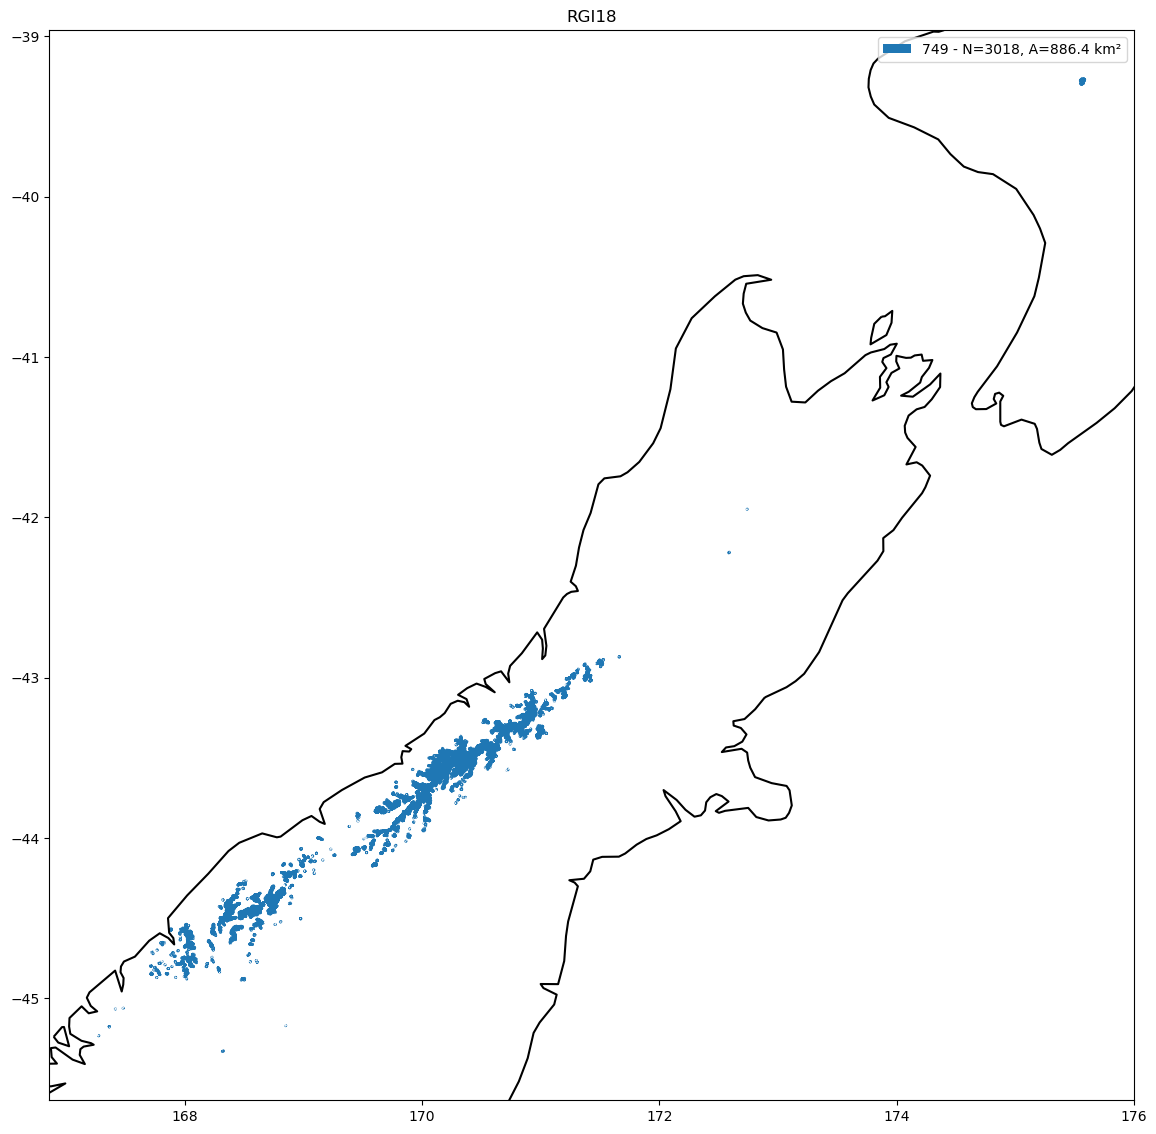

In [13]:
plot_map(rgi7, reg, linewidth=2)

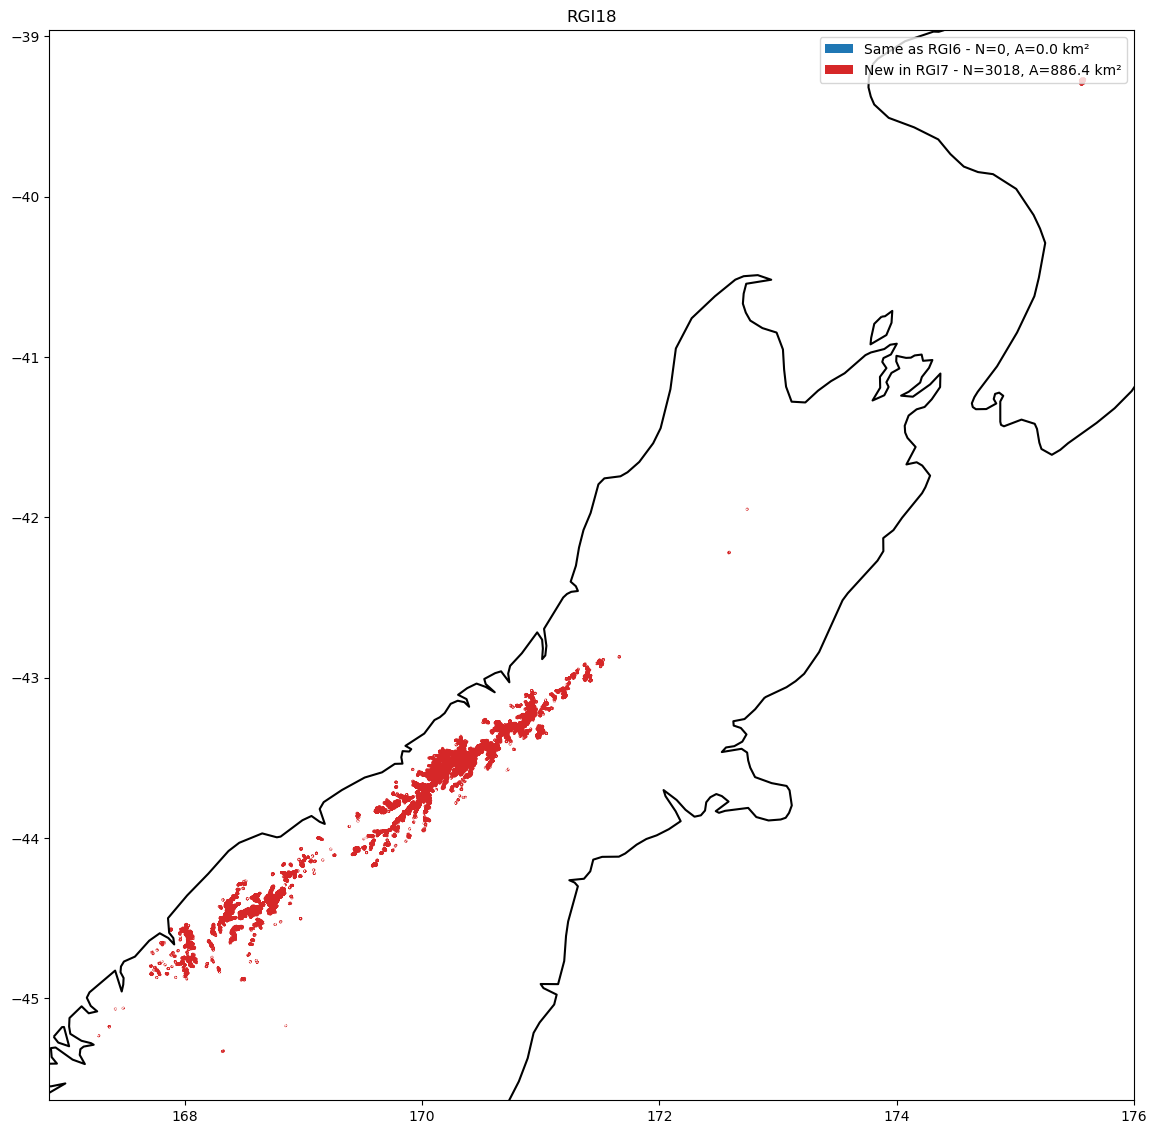

In [14]:
plot_map(rgi7, reg, linewidth=2, is_rgi6=True)

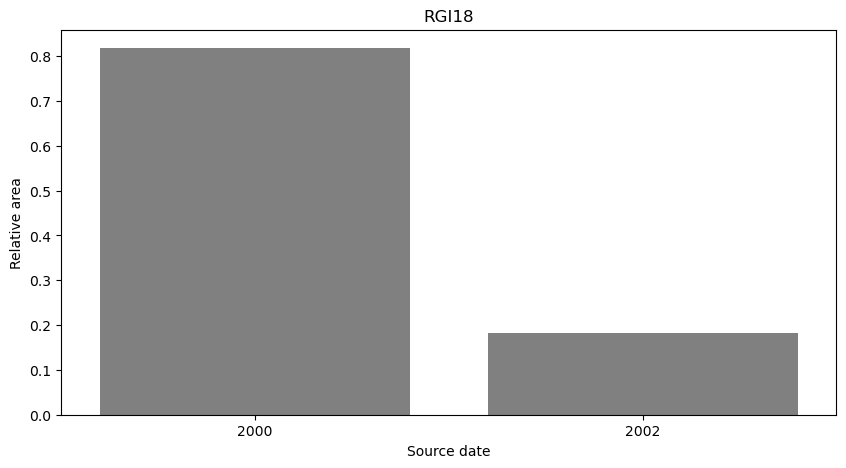

In [15]:
plot_date_hist(rgi7, reg)

### Text for github

In [16]:
fgh = sdf.loc[rgi7.subm_id.unique().astype(int)].T
fgh

subm_id,749
N,3018
A,886.4
analysts,"Baumann, Paul, Rastner"
submitters,Paul
release_date,2021
geog_area,Various (GlobGlacier)
src_date_mode,2000
src_date_min,2000
src_date_max,2002


In [17]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 749                    |
|:--------------|:-----------------------|
| N             | 3018                   |
| A             | 886.4                  |
| analysts      | Baumann, Paul, Rastner |
| submitters    | Paul                   |
| release_date  | 2021                   |
| geog_area     | Various (GlobGlacier)  |
| src_date_mode | 2000                   |
| src_date_min  | 2000                   |
| src_date_max  | 2002                   |


## Write out and tar 

In [18]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI18/
RGI18/RGI18.dbf
RGI18/RGI18.shp
RGI18/RGI18.cpg
RGI18/RGI18.prj
RGI18/RGI18.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI18.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI18'], returncode=0)


## New RGI-file created - Check result!

### load reference data comparison

In [16]:
support_dir = os.path.join(data_dir, 'l0_support_data')

In [17]:
# RGI6
from utils import open_zip_shapefile
ref_rgi6 = open_zip_shapefile(rgi6_reg_file)

# FP
df_ref = open_zip_shapefile(os.path.join(support_dir, 'new_zealand2000.zip'))

### Number of elements

In [18]:
print('Number of glaciers in new RGI subset:', len(rgi7))
print('Number of glaciers in reference data:', len(df_ref))
print('Difference:', len(rgi7)-len(df_ref))
print('Number of glaciers in RGI6:', len(ref_rgi6))

Number of glaciers in new RGI subset: 3018
Number of glaciers in reference data: 3018
Difference: 0
Number of glaciers in RGI6: 3537


### Total area

In [19]:
# add an area field to the selected GAMDAM table
df_ref['area'] = df_ref.to_crs({'proj':'cea'}).area
ref_rgi6['area'] = ref_rgi6.to_crs({'proj':'cea'}).area

In [20]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_ref = df_ref['area'].sum() * 1e-6
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

Area RGI [km²]: 886.4041457633251
Area Ref [km²]: 886.4053915325577
Area difference [km²]: -0.001245769232582461


In [21]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

Area RGI7 [km²]: 886.4041457633251
Area RGI6 [km²]: 1161.7753563763804
Area difference [km²]: -275.37121061305527
